# Imports

## Misc imports

In [1]:
import os
import cv2
from tqdm import tqdm
from collections import Counter

In [20]:
from tensorflow.keras.models import load_model

## Machine Learning imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, precision_score, classification_report
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import to_categorical

# Data

## Data Loading And Preprocessing

In [4]:
img_size = 200

data_path = "../Data"

datas = os.listdir(os.path.join(data_path, "train"))
images_train = []
images_test = []
images_val = []

class_num = -1
for data in datas:
    class_num += 1
    for img in tqdm(os.listdir(os.path.join(data_path, "train", data)), desc=f"train data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "train", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_train.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    for img in tqdm(os.listdir(os.path.join(data_path, "test", data)), desc=f"test data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "test", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_test.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    for img in tqdm(os.listdir(os.path.join(data_path, "valid", data)), desc=f"val data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "valid", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_val.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    if class_num == 15:
        class_num += 1
        break

val data AMERICAN BITTERN --->: 100%|██████████| 5/5 [00:00<00:00, 90.75it/s]


## Split And Encoding

In [5]:
X_train = []
y_train = []
for data in images_train:
    X_train.append(data["Image"])
    y_train.append(data["Class"])
X_test = []
y_test = []
for data in images_test:
    X_test.append(data["Image"])
    y_test.append(data["Class"])
X_val = []
y_val = []
for data in images_val:
    X_val.append(data["Image"])
    y_val.append(data["Class"])


X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)
X_val = np.array(X_val).reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

In [6]:
y_train_encoded = to_categorical(y_train, num_classes=class_num)
y_test_encoded = to_categorical(y_test, num_classes=class_num)
y_val_encoded = to_categorical(y_val, num_classes=class_num)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(y_train_encoded.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test_encoded.shape)
print(X_val.shape)
print(y_val.shape)
print(y_val_encoded.shape)

(2592, 200, 200, 3)
(2592,)
(2592, 16)
(80, 200, 200, 3)
(80,)
(80, 16)
(80, 200, 200, 3)
(80,)
(80, 16)


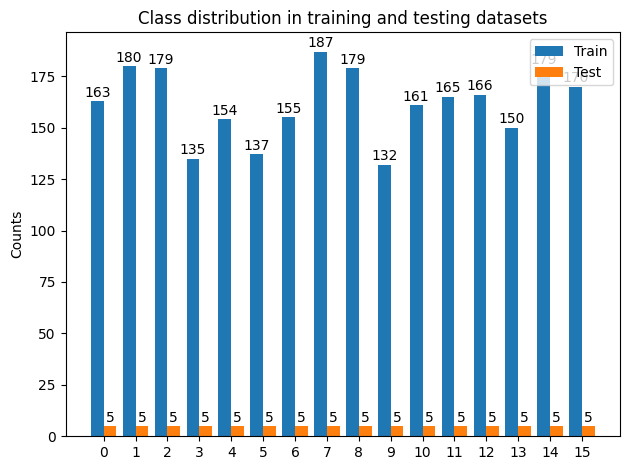

In [8]:
def visualize_class_distribution(y_train, y_test):
    """
    Visualizes the class distribution in training and testing datasets when the labels are provided as lists.
    Adds a numeric label at the top of each bar showing the count.

    Parameters:
    - y_train: List of training labels.
    - y_test: List of testing labels.
    """
    train_counter = Counter(y_train)
    test_counter = Counter(y_test)

    all_labels = list(set(train_counter.keys()).union(set(test_counter.keys())))
    all_labels.sort()  # Sort the labels for consistent plotting
    train_counts = [train_counter[label] for label in all_labels]
    test_counts = [test_counter[label] for label in all_labels]

    x = range(len(all_labels))  # Label locations

    fig, ax = plt.subplots()
    train_bars = ax.bar([i - 0.2 for i in x], train_counts, width=0.4, label='Train', align='center')
    test_bars = ax.bar([i + 0.2 for i in x], test_counts, width=0.4, label='Test', align='center')

    ax.set_ylabel('Counts')
    ax.set_title('Class distribution in training and testing datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(all_labels, rotation='horizontal')
    ax.legend()

    def autolabel(bars):
        """Attach a text label above each bar displaying its height."""
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(train_bars)
    autolabel(test_bars)

    plt.tight_layout()
    plt.show()

visualize_class_distribution(y_train, y_test)

# Machine Learning

## CNN Model

In [12]:
model = Sequential(
    [
        Conv2D(32, (4, 4), activation="relu", input_shape=(img_size, img_size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(class_num, activation="softmax")
    ]
)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 197, 197, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    17,334,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,492,880 (66.73 MB)

 Trainable params: 17,492,880 (66.73 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model_history = model.fit(X_train, y_train_encoded, epochs=3, validation_data=(X_val, y_val_encoded))

Epoch 1/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 803ms/step - accuracy: 0.9590 - loss: 0.1623 - precision: 0.9645 - recall: 0.9502 - val_accuracy: 0.7750 - val_loss: 1.2721 - val_precision: 0.7792 - val_recall: 0.7500
Epoch 2/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 59s 734ms/step - accuracy: 0.9783 - loss: 0.0739 - precision: 0.9819 - recall: 0.9743 - val_accuracy: 0.8125 - val_loss: 1.0176 - val_precision: 0.8312 - val_recall: 0.8000
Epoch 3/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 782ms/step - accuracy: 0.9831 - loss: 0.0609 - precision: 0.9831 - recall: 0.9812 - val_accuracy: 0.7500 - val_loss: 1.0961 - val_precision: 0.7792 - val_recall: 0.7500


In [36]:
prediction = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 632ms/step


In [37]:
pred = np.argmax(prediction, axis=1)

In [1]:
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

NameError: name 'accuracy_score' is not defined

In [39]:
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

           0       0.36      0.80      0.50         5
           1       1.00      0.20      0.33         5
           2       0.71      1.00      0.83         5
           3       0.80      0.80      0.80         5
           4       1.00      0.80      0.89         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      0.40      0.57         5
          11       0.80      0.80      0.80         5
          12       0.83      1.00      0.91         5
          13       0.50      0.60      0.55         5
          14       0.75      0.60      0.67         5
          15       0.67      0.80      0.73         5

    accuracy                           0.75        80
   macro avg       0.81   

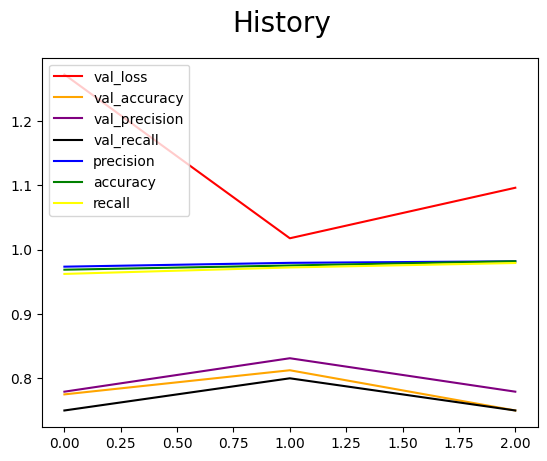

In [40]:
fig = plt.figure()
plt.plot(model_history.history["val_loss"], color='red', label="val_loss")
plt.plot(model_history.history["val_accuracy"], color='orange', label="val_accuracy")
plt.plot(model_history.history["val_precision"], color='purple', label="val_precision")
plt.plot(model_history.history["val_recall"], color='black', label="val_recall")
plt.plot(model_history.history["precision"], color='blue', label="precision")
plt.plot(model_history.history["accuracy"], color='green', label="accuracy")
plt.plot(model_history.history["recall"], color='yellow', label="recall")
fig.suptitle("History", fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [42]:
model.save("../Models/basic_cnn_model.h5")